In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.decomposition import PCA
from scipy.stats import entropy


In [35]:
def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
    }

    # Create an empty DataFrame to store accuracy
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        print(f"{name} Accuracy:", accuracy)
        model_performance.append({"Model": name, "Accuracy": accuracy})

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    print(f"Sequential Model Accuracy: {accuracy}")
    print(f"Sequential Model Loss: {loss}")
    model_performance.append({"Model": "Sequential", "Accuracy": accuracy})

    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

In [42]:
df = pd.read_csv("housing_price_dataset.csv")
df

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065
...,...,...,...,...,...,...
49995,1282,5,3,Rural,1975,100080.865895
49996,2854,2,2,Suburb,1988,374507.656727
49997,2979,5,3,Suburb,1962,384110.555590
49998,2596,5,2,Rural,1984,380512.685957


In [43]:
df.isna().sum()

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.dtypes

SquareFeet        int64
Bedrooms          int64
Bathrooms         int64
Neighborhood     object
YearBuilt         int64
Price           float64
dtype: object

In [7]:
df["Neighborhood"].value_counts()

Neighborhood
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64

In [44]:
neighborhood_keys = {"Suburb": 0, "Rural": 1, "Urban": 2}
df["Neighborhood"] = df["Neighborhood"].apply(lambda x: neighborhood_keys[x])

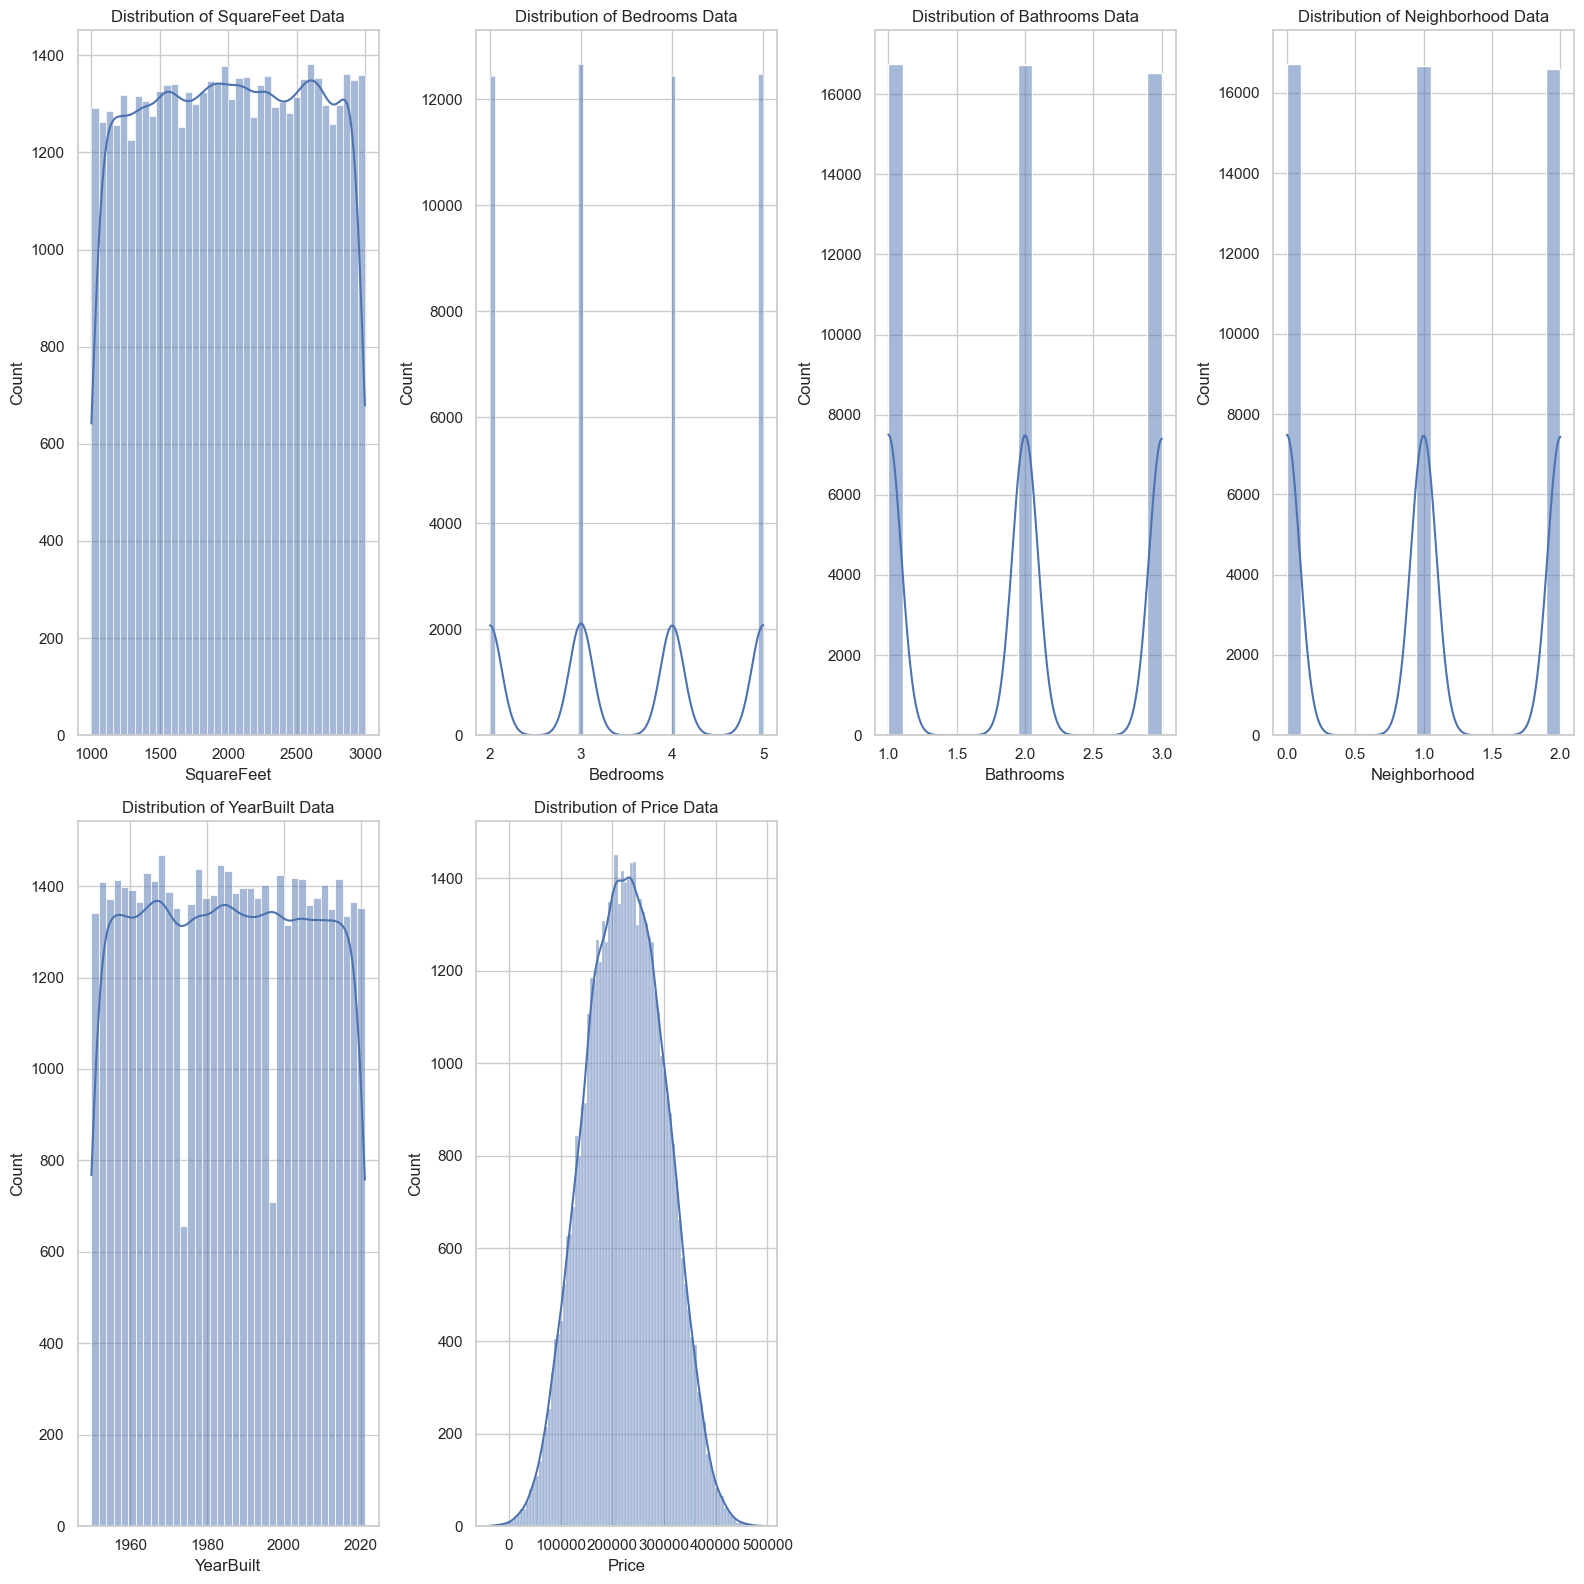

In [45]:
plt.figure(figsize = (16, 16))
num_plots = len(df.columns) - 1  # Exclude the last column
rows = (num_plots + 3) // 4  # Calculate the number of rows needed, add 3 to round up

for i, col in enumerate(df.columns):
    plt.subplot(rows, 4, i+1)
    sns.histplot(df[col], kde= True)
    plt.title(f"Distribution of {col} Data")
    plt.tight_layout()
    plt.plot()

In [48]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 -Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Filter out outliers and keep data within the IQR
filtered_df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

In [49]:
filtered_df["Price"].max()

443335.4943376072

In [51]:
df[df["Price"] <0]

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
1266,1024,2,2,2,2006,-24715.242482
2310,1036,4,1,0,1983,-7550.504574
3630,1235,3,2,1,2012,-19871.251146
4162,1352,5,2,0,1977,-10608.359522
5118,1140,4,1,2,2020,-23911.003119
5951,1097,4,3,1,1981,-4537.418615
6355,1016,5,2,1,1997,-13803.684059
8720,1235,3,1,2,1952,-24183.000515
9611,1131,3,3,2,1959,-13692.026068
10597,1177,2,3,2,2010,-434.097124


In [50]:
filtered_df["Price"].min()

6124.032173620857

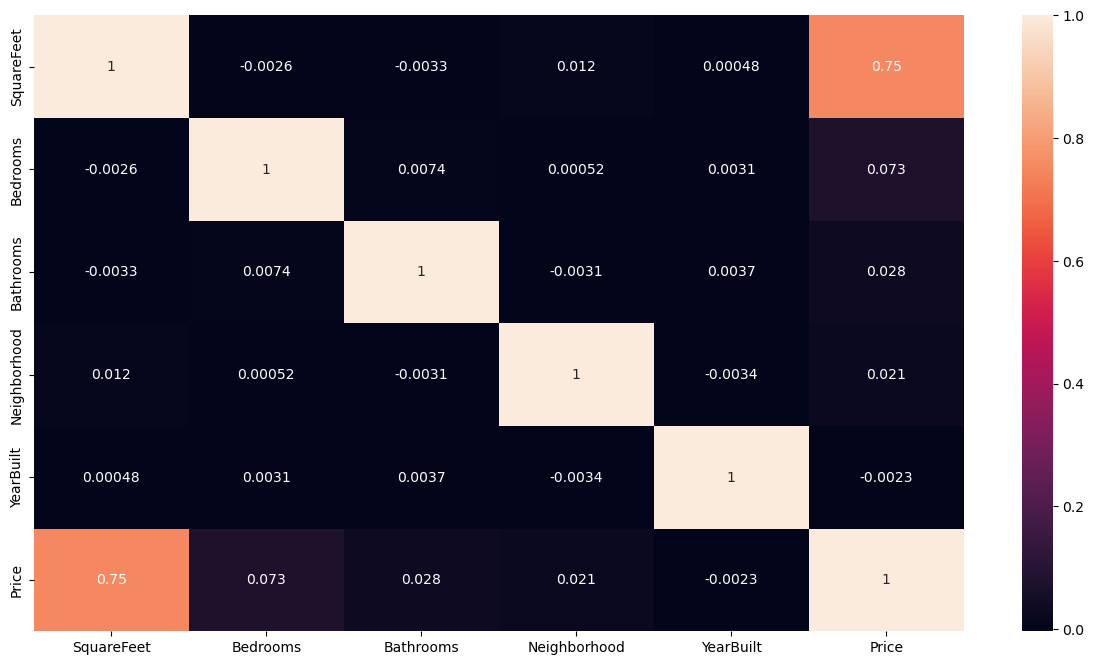

In [9]:
plt.figure(figsize=(15,8))
relations = df.corr()
sns.heatmap(data=relations,annot=True)
plt.show()

In [13]:
X, y = df.drop("Price", axis=1), df["Price"]


X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
lr = LinearRegression()

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

lr.fit(X_train_scaled, y_train_encoded)
predictions = lr.predict(X_test_scaled)
accuracy = lr.score(X_test_scaled, y_test_encoded)
accuracy

0.5755522736027551

In [14]:

forest = RandomForestRegressor()

forest.fit(X_train_scaled, y_train_encoded)

forest.score(X_test_scaled,y_test_encoded)

0.517934803861394

In [15]:
from sklearn.model_selection import GridSearchCV


param_grid = {
  "n_estimators":[3,10,30],
  "max_features": [2,4,6,8]
}

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(X_train_scaled, y_train_encoded)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [16]:
best_forest = grid_search.best_estimator_

In [18]:
best_forest.score(X_test_scaled, y_test_encoded)

0.5115645405796365

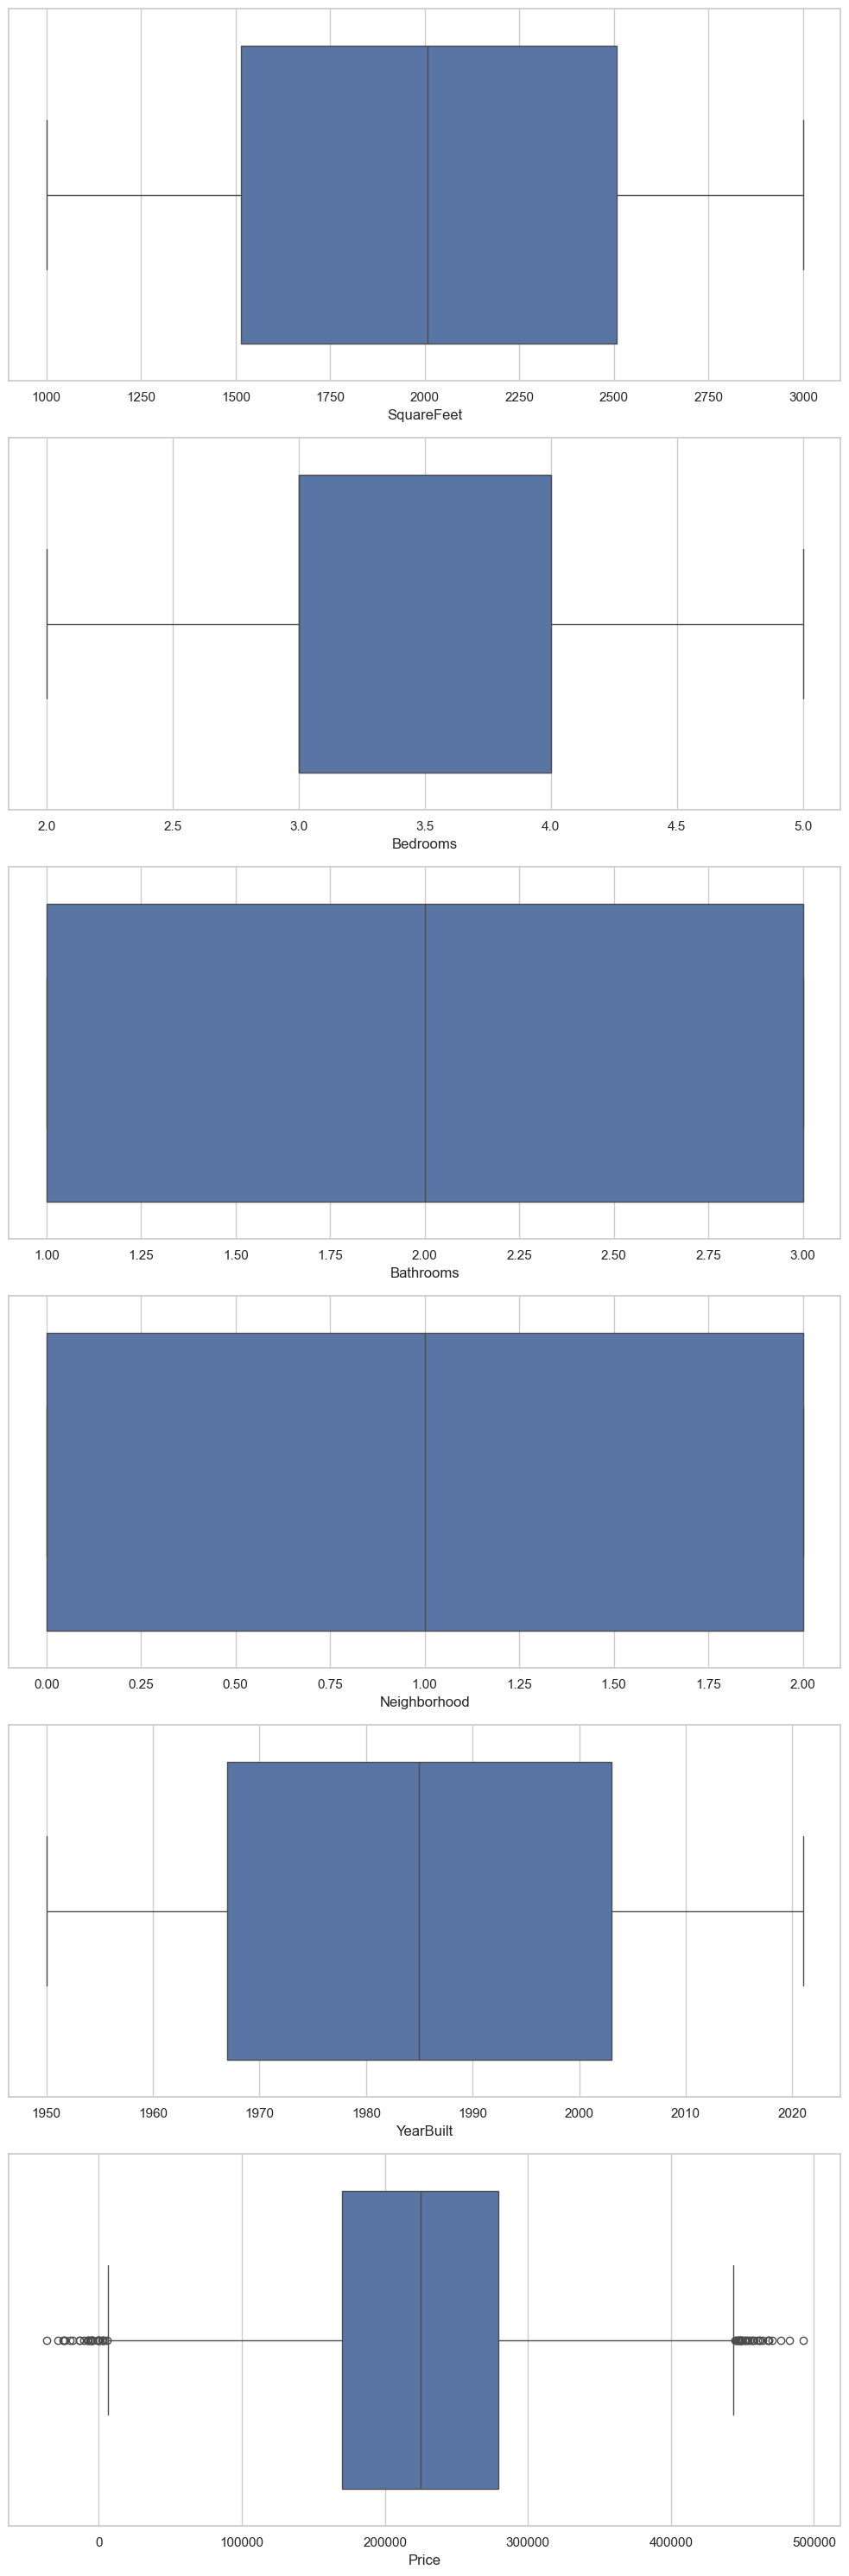

In [19]:

sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 5 * len(df.columns)))

# Iterate through columns and create box plots
for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 -Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Filter out outliers and keep data within the IQR
filtered_df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

In [22]:
X, y = filtered_df.drop("Price", axis=1), filtered_df["Price"]


X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
lr = LinearRegression()

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

lr.fit(X_train_scaled, y_train_encoded)
predictions = lr.predict(X_test_scaled)
accuracy = lr.score(X_test_scaled, y_test_encoded)
accuracy

0.5665192789359861

In [23]:

forest = RandomForestRegressor()

forest.fit(X_train_scaled, y_train_encoded)

forest.score(X_test_scaled,y_test_encoded)

0.513138302786039

In [24]:

param_grid = {
  "n_estimators":[3,10,30],
  "max_features": [2,4,6,8]
}

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(X_train_scaled, y_train_encoded)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [25]:
best_forest = grid_search.best_estimator_
best_forest.score(X_test_scaled, y_test_encoded)

0.5043136695603836

In [28]:
X, y = filtered_df.drop("Price", axis=1), filtered_df["Price"]


X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
lr = LinearRegression()

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

lr.fit(X_train_scaled, y_train_encoded)
predictions = lr.predict(X_test_scaled)
accuracy = lr.score(X_test_scaled, y_test_encoded)
accuracy

0.5665192789359861

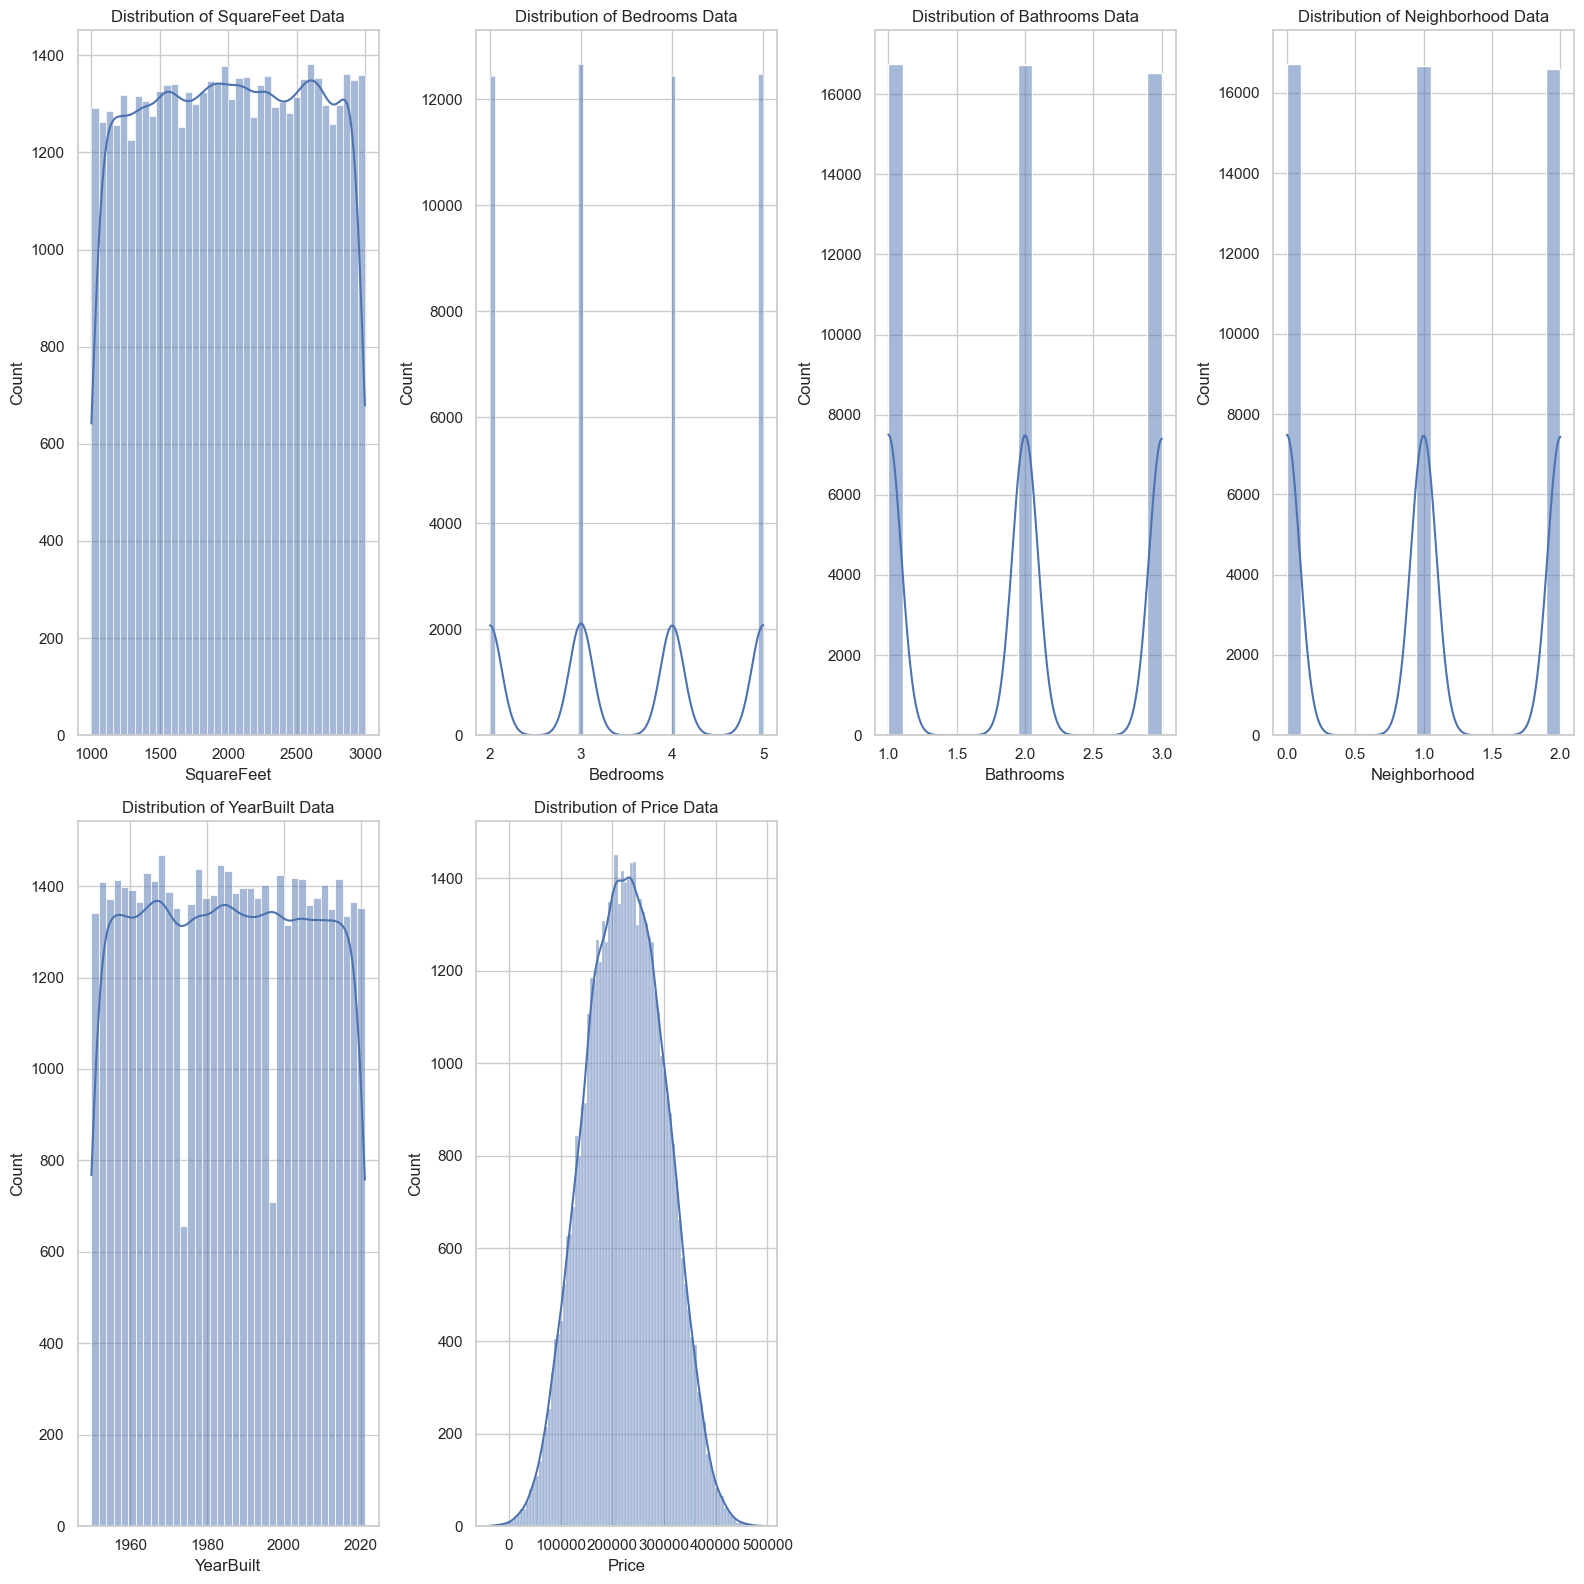

In [38]:
plt.figure(figsize = (16, 16))
num_plots = len(df.columns) - 1  # Exclude the last column
rows = (num_plots + 3) // 4  # Calculate the number of rows needed, add 3 to round up

for i, col in enumerate(df.columns):
    plt.subplot(rows, 4, i+1)
    sns.histplot(df[col], kde= True)
    plt.title(f"Distribution of {col} Data")
    plt.tight_layout()
    plt.plot()

In [39]:
df.describe()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,0.997640,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,0.816387,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,0.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,0.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2.000000,2021.000000,492195.259972


In [40]:
df["Price"].max()

492195.25997201505

In [41]:
df["Price"].min()

-36588.16539749279